# Gaussian Process Regression (v2)
...

In [1]:
from cvxopt import matrix, spmatrix, sin, sqrt, log
import matplotlib.pyplot as plt
import numpy as np
import gp

import finite_difference_method

## Generate Data
We generate via the model
    $$y(x) = f(x) + \epsilon,$$
were $f(x) = sin(x)$, $\epsilon \sim \mathcal{N}(0,0.1^2)$ and $x \in [-5,5]$. 

The data is generated at discrete times, $x_{k}$ for $k \in {0,1,\dots,N}$, such that the data 
    $$y_{k} = f(x_{k}) + \epsilon_{k}.$$
Both the true model values, $f(x_{k})$, and the noisy model values, $y_{k}$, are stored.

In [23]:
## Data generation function
generate_data = gp.data.generate_data

## Define boundaries and grid
xmin   = -5
xmax   = 5
N      = 100
outfun = lambda x: sin(x)
noise  = 1e-2

## Generate data
X, Y, Y_true = generate_data( xmin, xmax, N, outfun, noise )

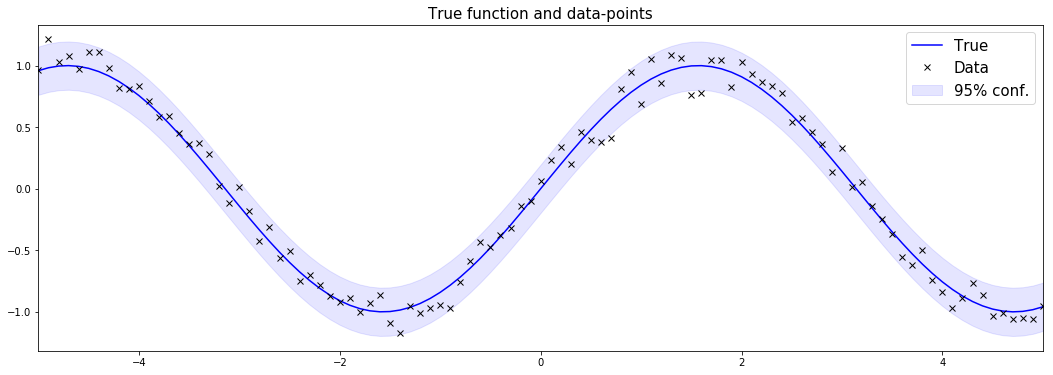

In [24]:
""" Plot Data and True Function """
fontsize = 15

fig, ax = plt.subplots( figsize=(18,6) )

## Fit for tau_1
ax.set_title( 'True function and data-points', fontsize=fontsize )

p = [None]*3
p[0], = ax.plot( X, Y_true, 'b' , label='True' )
p[1], = ax.plot( X, Y     , 'kx', label='Data' )

X_fill = np.array(X).reshape(X.size[0],)
Yu_fill = np.array(Y_true + 1.96*sqrt(noise)).reshape(X.size[0],)
Yl_fill = np.array(Y_true - 1.96*sqrt(noise)).reshape(X.size[0],)
p[2] = ax.fill_between( X_fill, Yl_fill, Yu_fill, color='blue', alpha=0.1, label='95% conf.' )

ax.set_xlim(xmin, xmax)
ax.legend( handles=p, fontsize=fontsize )
plt.show()

## Training the Gaussian Process
...

In [25]:
## Define prior, kernel and training functions
m     = gp.priors.pzero
k     = gp.kernels.sqexp
train = gp.training.train.train


## Define Training data as sub-set of full data
np.random.seed(101)
n_id    = 25                                                     # Size of training data
x_id    = matrix( np.random.choice( N+1, n_id, replace=False ) ) # Training data indecies
x_train = X[x_id]                                                # Training data (X)
y_train = Y[x_id]                                                # Training data (Y)


## Train GP( m(.), k(.,.) )
mu, Sigma = train( x_train, m, k, lambda_=2.0 )

## Predict using Gaussian Process
...

(101, 1)
0.011799325513266345


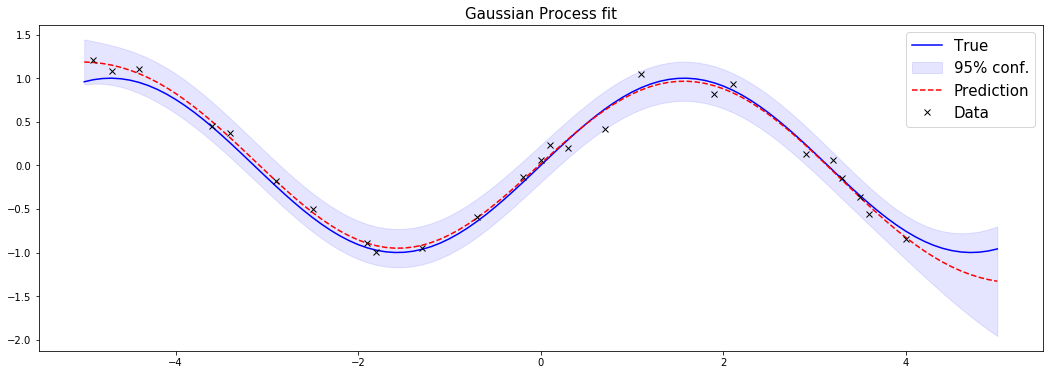

In [26]:
""" Prediction using Gaussian Process Fit """
## Define prediction function
predict = gp.prediction.predict.predict

## Run prediction
Y_pred     = matrix( 0.0, (Y.size[0],1) )
Sigma_pred = matrix( 0.0, (Y.size[0],1) )
for i in range(X.size[0]):
    Y_pred[i], Sigma_pred[i] = predict( X[i], x_train, y_train, mu, Sigma, m, k, sigma=1e-1, lambda_=2.0 )


""" Visualisation """
fontsize = 15

fig, ax = plt.subplots( figsize=(18,6) )

## Fit for tau_1
ax.set_title('Gaussian Process fit', fontsize=fontsize )

print( Y_pred.size )
print( min(Sigma_pred) )

p = [None]*4
X_fill = np.array(X).reshape(X.size[0],)
Yu_fill = np.array(Y_pred + 1.96*sqrt(Sigma_pred)).reshape(Y_pred.size[0],)
Yl_fill = np.array(Y_pred - 1.96*sqrt(Sigma_pred)).reshape(Y_pred.size[0],)
p[0], = ax.plot( X, Y_true, 'b', label='True' )
p[1]  = ax.fill_between( X_fill, Yl_fill, Yu_fill, color='blue', alpha=0.1, label='95% conf.' )
p[2], = ax.plot( X      , Y_pred , 'r--', label='Prediction' )
p[3], = ax.plot( x_train, y_train, 'kx' , label='Data')
ax.legend( handles=p, fontsize=fontsize );

## Maximum Likelihood Estimation
Not good when you only have few observations.

[ 4.14e+00]
 [ 5.96e-01]



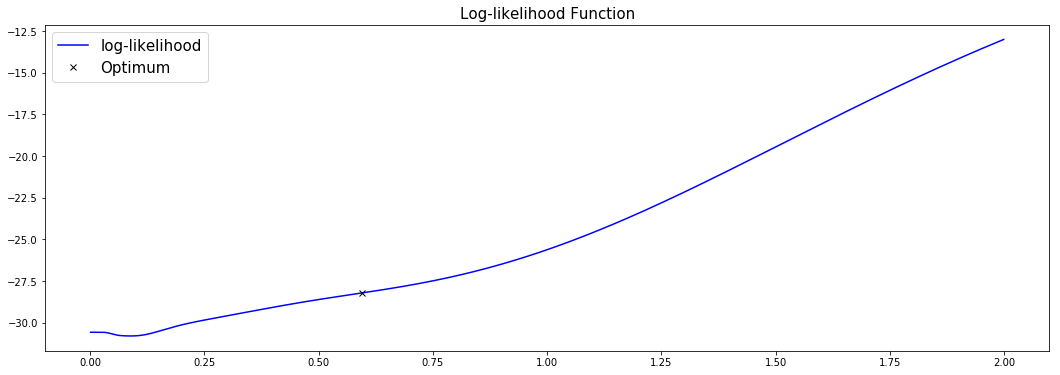

In [27]:
""" Likelihood Function """
def log_likelihood( sigma, x, y, m, k, lambda_ ):
    x = matrix(x) # Training data
    y = matrix(y) # Training data
    
    _, K = train( x, m, k, lambda_=lambda_ )
    
    ## Define identity
    n = x.size[0]
    I_n = matrix( spmatrix( 1.0, range(n), range(n) ) )
    
    ## Define co-variance
    Sigma     = K + sigma*I_n
    Sigma_inv = matrix( np.linalg.inv(Sigma) )
    Sigma_det = matrix( np.linalg.det(Sigma) )
    return -0.5*y.T*Sigma*y - 0.5*log(Sigma_det) - 0.5*n*log(2*np.pi)


## Likelihood function - ll( sigma )
ll  = lambda lambda_: log_likelihood( 1e-1, x_train, y_train, m, k, lambda_ )

## Numerical first order derivative - dll( sigma )
dll = lambda lambda_: finite_difference_method.fdm( ll, lambda_ )


## Evaluate likelihood function
N_sigma = int(1e+3)
sigma_x = matrix( range(N_sigma*2) ) / N_sigma;
sigma_x = sigma_x[1:]
sigma_y = matrix( 0.0, (sigma_x.size[0],1) )
for i in range(sigma_x.size[0]):
    sigma_y[i] = ll(sigma_x[i])


## Compute optimal likelihood - numerical gradient descent method
it = 0
lambda_k = 0.6
while np.abs(dll(lambda_k)) > 1e-6 and it < 1e+1:
    lambda_k -= 1e-4*dll(lambda_k)
    it += 1
    

## Visualise likelihood
p = [None]*2
fig, ax = plt.subplots( figsize=(18,6) )
ax.set_title( 'Log-likelihood Function', fontsize=fontsize )
p[0], = ax.plot( sigma_x, sigma_y, 'b', label='log-likelihood' )
p[1], = ax.plot( lambda_k, ll(lambda_k), 'kx', label='Optimum' )
ax.legend( handles=p, fontsize=fontsize )
print( dll(lambda_k), lambda_k )

(101, 1)
-13.661980090058863


ValueError: domain error

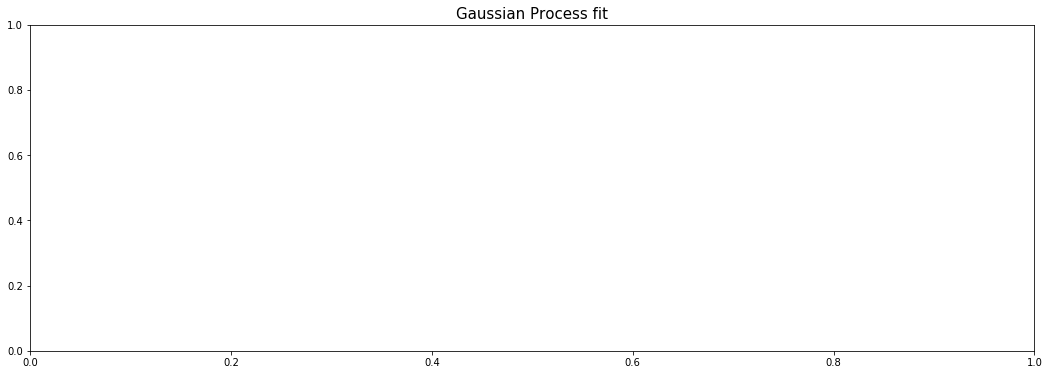

In [28]:
## Train GP( m(.), k(.,.) )
mu, Sigma = train( x_train, m, k, lambda_=1.5 )

## Run prediction
Y_pred     = matrix( 0.0, (Y.size[0],1) )
Sigma_pred = matrix( 0.0, (Y.size[0],1) )
for i in range(X.size[0]):
    Y_pred[i], Sigma_pred[i] = predict( X[i], x_train, y_train, mu, Sigma, m, k, sigma=1e-1, lambda_=lambda_k )


""" Visualisation """
fontsize = 15

fig, ax = plt.subplots( figsize=(18,6) )

## Fit for tau_1
ax.set_title('Gaussian Process fit', fontsize=fontsize )

print( Y_pred.size )
print( min(Sigma_pred) )

p = [None]*4
X_fill = np.array(X).reshape(X.size[0],)
Yu_fill = np.array(Y_pred + 1.96*sqrt(Sigma_pred)).reshape(Y_pred.size[0],)
Yl_fill = np.array(Y_pred - 1.96*sqrt(Sigma_pred)).reshape(Y_pred.size[0],)
p[0], = ax.plot( X, Y_true, 'b', label='True' )
p[1]  = ax.fill_between( X_fill, Yl_fill, Yu_fill, color='blue', alpha=0.1, label='95% conf.' )
p[2], = ax.plot( X      , Y_pred , 'r--', label='Prediction' )
p[3], = ax.plot( x_train, y_train, 'kx' , label='Data')
ax.legend( handles=p, fontsize=fontsize );